# Text Module Tutorial 3: Machine Learning Classification

This tutorial demonstrates how to perform machine learning analysis of text data.

In [1]:
# basic manipulation and plotting
import pandas as pd
import matplotlib.pyplot as plt

# machine learning imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

# pvops functionality
from pvops.text import utils as text_utils
from pvops.text import nlp_utils as text_nlp_utils
from pvops.text import visualize as text_visualize
from pvops.text import preprocess as text_preprocess
from pvops.text import defaults as text_defaults
from pvops.text import classify as text_classify

### Preprocessing

See text module tutorial 1 for more information on preprocessing steps. Here, we quickly run through them.

In [2]:
# read in dataset
df = pd.read_csv('example_data/example_ML_ticket_data.csv')

# perform asset label remapping
remapping_df = pd.read_csv('example_data/remappings_asset.csv')
remapping_col_dict = dict(attribute_col='Asset', 
                          remapping_col_from='in',
                          remapping_col_to='out_')
df = text_utils.remap_attributes(df, remapping_df, remapping_col_dict, allow_missing_mappings=True)

# let's only keep asset labels which have more than one instance in the dataset
label_counts = df.value_counts('Asset')
labels_with_multiple_occurrences = label_counts.loc[label_counts > 1].index
df = df.loc[df['Asset'].isin(labels_with_multiple_occurrences)]

# bulid a custom set of stopwords
stopwords = text_nlp_utils.create_stopwords(lst_add_words=['dtype', 'say', 'length', 'object', 'u', 'ha', 'wa'])

# run our preprocessing function to clean up the text data and prepare it for ML
col_dict = dict(data='CompletionDesc',
                eventstart='Date_EventStart',
                save_data_column='CleanDesc',
                save_date_column='ExtractedDates')
df = text_preprocess.preprocessor(df, stopwords, col_dict)

### Supervised classification of tickets using a cross-validated grid search

`pvops.text.classify.classification_deployer` provides an interface for performing classification using cross-validated grid search. It takes several arguments:
- `X` and `y`: the predictors and target variables
- `n_splits`: the number of splits for cross-validation
- `classifiers`: a dict whose values are classifier instances
- `search_space`: a dict whose values are hyperparameters to try for each classifier
- `pipeline_steps`: machine learning pipeline, e.g. document embedding, then classification
- `scoring`: the scoring function used to evaluate predictions
- `verbose`: controls how much is printed

In this example, let's try to predict the asset label given the textual description of the ticket. So we'll set our X and y correspondingly:

In [3]:
X, y = df['CleanDesc'], df['Asset']

Next, we'll define our pipeline and scorer using functionality from scikit-learn:

In [4]:
pipeline_steps = [('tfidf', TfidfVectorizer()), ('clf', None)]
scoring = metrics.make_scorer(metrics.f1_score, average='weighted', pos_label=None)

To help with searching over a wide range of models and parameters, `pvops.text.defaults.supervised_classifier_defs` has a set of pre-selected models and hyperameters. We can call it with the `'light'` argument to get a small grid to search over. We can also add some arguments to pass to the vectorizer step in our pipeline.

In [5]:
search_space, classifiers = text_defaults.supervised_classifier_defs('light')
for model_label in search_space.keys():
    search_space[model_label]["tfidf__ngram_range"] = [(1, 3)]
    search_space[model_label]["tfidf__stop_words"] = [None]

We're ready to go ahead and call our classification deployer:

In [6]:
results_df, best_model = text_classify.classification_deployer(
    X=X,
    y=y,
    n_splits=2,
    classifiers=classifiers,
    search_space=search_space,
    pipeline_steps=pipeline_steps,
    scoring=scoring,
    verbose=0,
)

c:\Users\agmoore\AppData\Local\anaconda3\envs\pvops\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Now, let's take a look at the result. We can print the best model, or take a look at the whole set of models and their performance:

In [7]:
print(best_model)

# organize columns
cols = ["estimator", "min_score", "mean_score", "max_score", "std_score", "mean_fit_time"]
cols += [c for c in results_df.columns if c not in cols]
results_df = results_df[cols]

# sort values and display top models
results_df = results_df.sort_values("mean_score", ascending=False)
results_df.head()

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf',
                 PassiveAggressiveClassifier(C=0.1, loss='squared_hinge'))])


estimator min_score mean_score max_score std_score  \
36  PassiveAggressiveClassifier  0.556463   0.581591  0.606719  0.025128   
35  PassiveAggressiveClassifier  0.556463   0.566256   0.57605  0.009794   
30           LogisticRegression   0.54385   0.562954  0.582058  0.019104   
34  PassiveAggressiveClassifier  0.542314   0.560283  0.578253   0.01797   
40              RidgeClassifier  0.516618   0.553447  0.590277  0.036829   

   mean_fit_time clf__criterion clf__min_samples_leaf clf__min_samples_split  \
36      0.074563            NaN                   NaN                    NaN   
35       0.09775            NaN                   NaN                    NaN   
30      0.085268            NaN                   NaN                    NaN   
34      0.114146            NaN                   NaN                    NaN   
40      0.068333            NaN                   NaN                    NaN   

   clf__splitter tfidf__ngram_range tfidf__stop_words   clf__C clf__solver  \
36           NaN             (1, 3)              None      0.1         NaN   
35           NaN             (1, 3)              None      0.1         NaN   
30           NaN             (1, 3)              None  10000.0         sag   
34           NaN             (1, 3)              None     0.01         NaN   
40           NaN             (1, 3)              None      NaN         NaN   

        clf__loss clf__alpha clf__n_estimators clf__max_samples  \
36  squared_hinge        NaN               NaN              NaN   
35          hinge        NaN               NaN              NaN   
30            NaN        NaN               NaN              NaN   
34  squared_hinge        NaN               NaN              NaN   
40            NaN      0.001               NaN              NaN   

   clf__algorithm clf__learning_rate  
36            NaN                NaN  
35            NaN                NaN  
30            NaN                NaN  
34            NaN                NaN  
40            NaN                NaN

### Unsupervised clustering on tickets using a cross-validated grid search

Suppose we would instead like to cluster tickets based on their embeddings. We can do so using `pvops.text.classify.classification_deployer` again, but instead using the grid provided by `pvops.text.defaults.unsupervised_classifier_defs`:

In [8]:
pipeline_steps = [("tfidf", TfidfVectorizer()), ("to_dense", text_nlp_utils.DataDensifier()), ("clf", None)]
scoring = metrics.make_scorer(metrics.homogeneity_score)

X, y = df['CleanDesc'], df['Asset']
n_clusters = len(y.unique()) # clustering requires a number of clusters as a hyperparameter; we'll match the ground truth number of clusters
search_space, classifiers = text_defaults.unsupervised_classifier_defs('normal', n_clusters)

unsupervised_results, unsupervised_best_model = text_classify.classification_deployer(
    X=X,
    y=y,
    n_splits=2,
    classifiers=classifiers,
    search_space=search_space,
    pipeline_steps=pipeline_steps,
    scoring=scoring,
    verbose=0,
)

c:\Users\agmoore\AppData\Local\anaconda3\envs\pvops\Lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


And we can take a look at the results again:

In [9]:
print(unsupervised_best_model)

# organize columns
cols = ["estimator", "min_score", "mean_score", "max_score", "std_score", "mean_fit_time"]
cols += [c for c in unsupervised_results.columns if c not in cols]
unsupervised_results = unsupervised_results[cols]

# sort values and display top models
unsupervised_results = unsupervised_results.sort_values("mean_score", ascending=False)
unsupervised_results.head()

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('to_dense', DataDensifier()),
                ('clf', Birch(n_clusters=9))])


estimator min_score mean_score max_score std_score mean_fit_time  \
7      Birch  0.471912   0.505757  0.539601  0.033845      0.912859   
4      Birch  0.471912   0.505757  0.539601  0.033845      0.848825   
10    KMeans  0.460578   0.487753  0.514928  0.027175      0.072986   
13    KMeans  0.419463   0.482515  0.545568  0.063052      0.043748   
12    KMeans  0.442211   0.447707  0.453202  0.005495      0.567438   

   clf__damping clf__max_iter clf__branching_factor clf__n_clusters  \
7           NaN           NaN                   100               9   
4           NaN           NaN                    50               9   
10          NaN           NaN                   NaN               9   
13          NaN           NaN                   NaN               9   
12          NaN           NaN                   NaN               9   

   clf__threshold  clf__init clf__n_init clf__bandwidth clf__bin_seeding  
7             0.5        NaN         NaN            NaN              NaN  
4             0.5        NaN         NaN            NaN              NaN  
10            NaN  k-means++          10            NaN              NaN  
13            NaN     random          10            NaN              NaN  
12            NaN  k-means++         100            NaN              NaN

We may then want to investigate patterns that the model picked up on. We can take the best-performing model, split the dataset according to its predictions, and plot the word frequencies for each label:

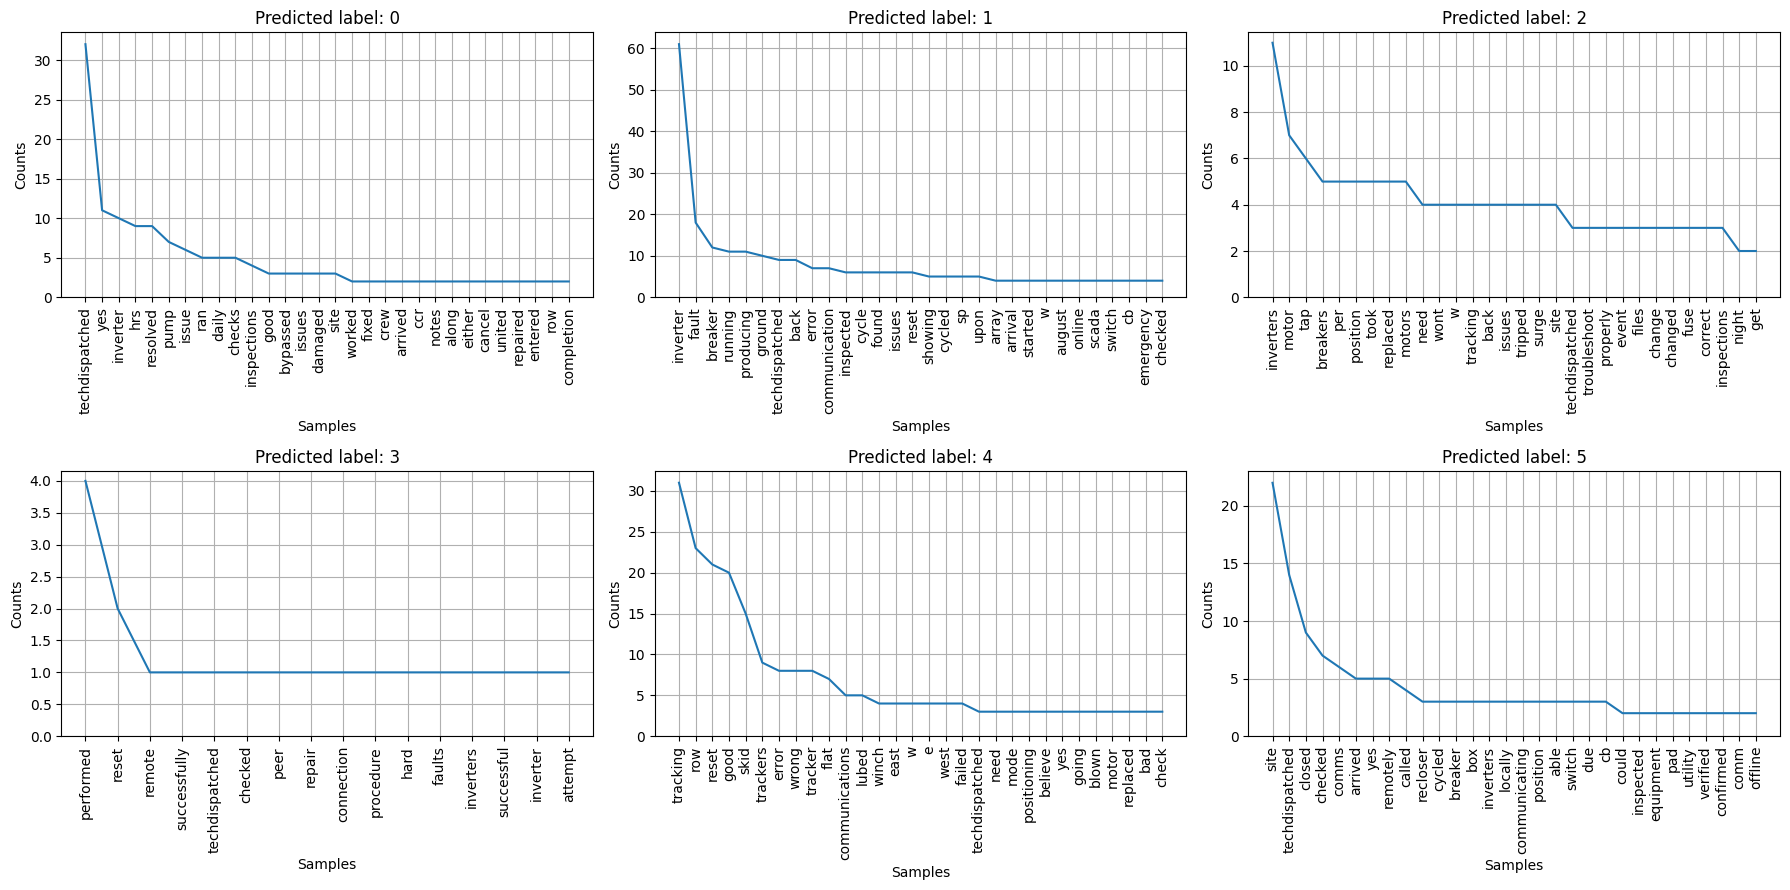

In [10]:
best_model_predictions = unsupervised_best_model.predict(df['CleanDesc'])
labels = set(best_model_predictions)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 9))

for label, ax in zip(labels, axes.flatten()):
    docs = df.loc[best_model_predictions == label, 'CleanDesc']
    tokenized = text_preprocess.regex_tokenize(' '.join(docs))
    text_visualize.visualize_word_frequency_plot(tokenized, f'Predicted label: {label}', ax=ax);

fig.tight_layout();

Seeing how often `techdispatched` appears across clusters, one might consider adding it to the stopwords list.